In [1]:
# Импорты
import os
import csv
import cv2
import json
import math
import pandas as pd
from time import time
import seaborn as sns
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
import vio_ort_exp as vio_ort

In [2]:
# Путь к директории с данными
set_dir = '2024_12_15_15_31_8_num_3'

In [3]:
# Чтение JSON-файлов
json_files = sorted([f for f in os.listdir(set_dir) if f.endswith('.json')])
start = 0  # Индекс начала обработки
count_json = len(json_files)  # Количество обрабатываемых файлов

In [4]:
# Инициализация визуальной инерциальной одометрии (VIO)
odometry = vio_ort.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)

In [5]:
# Определение параметров для экспериментов
top_k_values = [512, 256]  # Максимальное количество точек для сопоставления
detection_threshold_values = [0.05, 0.01]  # Порог детектирования ключевых точек
max_iters_values = [None, 100, 300, 500]  # Максимальное количество итераций оптимизации
rotation_methods = ["PIL", "CV2"]  # Методы поворота изображений
trace_values = [8, 4]  # Глубина трассировки

In [6]:
# Генерация всех возможных комбинаций параметров
parameters = [
    {'top_k': top_k, 'detection_threshold': detection_threshold, 'maxIters': max_iters, 'rotation': rotation, 'trace': trace}
    for top_k, detection_threshold, max_iters, rotation, trace in product(
        top_k_values, detection_threshold_values, max_iters_values, rotation_methods, trace_values
    )
]

In [7]:
def run_vio(odometry, json_files, start, count_json, top_k, detection_threshold, maxIters, rotation, trace, is_gps=True):
    """
    Выполняет обработку данных VIO с заданными параметрами.
    
    Параметры:
        odometry: Объект VIO.
        json_files: Список JSON-файлов.
        start: Индекс начала обработки.
        count_json: Количество файлов для обработки.
        top_k: Максимальное количество ключевых точек.
        detection_threshold: Порог детектирования.
        maxIters: Максимальное количество итераций.
        rotation: Метод поворота изображения.
        trace: Глубина трассировки.
        is_gps: Флаг использования данных GPS.
    
    Возвращает:
        Словарь с координатами VIO и GPS.
    """
    lat_VIO, lon_VIO, alt_VIO = [], [], []
    lat_GPS, lon_GPS, alt_GPS = [], [], []

    odometry._matcher.top_k = top_k
    odometry._matcher.detection_threshold = detection_threshold
    odometry.MAX_ITERS = maxIters
    odometry.ROTATION = rotation
    odometry.TRACE = trace

    for filename in json_files[start:start + count_json]:
        with open(f'{set_dir}/{filename}', 'r') as file:
            data = json.load(file)
            if 'GNRMC' in data and data['GNRMC']['status'] == 'A':
                img_path = os.path.join(set_dir, os.path.splitext(filename)[0] + '.jpg')
                image = cv2.imread(img_path)
                result_vio = odometry.add_trace_pt(image, data)

                lat_VIO.append(result_vio['lat'])
                lon_VIO.append(result_vio['lon'])
                alt_VIO.append(result_vio['alt'] * 1000)
                
                if is_gps:
                    lat_GPS.append(data['GNRMC'].get('lat', 0.0))
                    lon_GPS.append(data['GNRMC'].get('lon', 0.0))
                    alt_GPS.append(data['GPS_RAW_INT']['alt'])

    return {
        'lat_VIO': lat_VIO,
        'lon_VIO': lon_VIO,
        'alt_VIO': alt_VIO,
        'lat_GPS': lat_GPS,
        'lon_GPS': lon_GPS,
        'alt_GPS': alt_GPS,
    }

In [8]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Вычисляет расстояние между двумя точками на поверхности Земли.
    
    Параметры:
        lat1, lon1: Координаты первой точки.
        lat2, lon2: Координаты второй точки.
    
    Возвращает:
        Расстояние в метрах.
    """
    R = 6371000  # Радиус Земли в метрах
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2) ** 2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [9]:
def calculate_aggregated_metrics(results):
    """
    Рассчитывает агрегированные метрики (максимальное, минимальное расстояние, RMSE).
    
    Параметры:
        results: Словарь с координатами VIO и GPS.
    
    Возвращает:
        Словарь с метриками.
    """
    metrics = {"VIO": []}

    for i in range(len(results['lat_GPS'])):
        gps_lat, gps_lon = results['lat_GPS'][i], results['lon_GPS'][i]
        vio_lat, vio_lon = results['lat_VIO'][i], results['lon_VIO'][i]

        metrics["VIO"].append(haversine(gps_lat, gps_lon, vio_lat, vio_lon))

    distances = metrics["VIO"]
    aggregated = {
        "Metric": ["Max Distance (m)", "Min Distance (m)", "RMSE (m)"],
        "VIO": [max(distances), min(distances), math.sqrt(sum(d ** 2 for d in distances) / len(distances))]
    }

    return aggregated

In [10]:
def save_results_to_csv(results_all, filename):
    """
    Сохраняет результаты экспериментов в файл CSV.
    
    Параметры:
        results_all: Список результатов экспериментов.
        filename: Имя выходного CSV-файла.
    """
    with open(filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Top_k", "Detection Threshold", "Max Iters", "Rotation method", "Trace depth", "Max Distance", "Min Distance", "RMSE"])

        for result in results_all:
            params = result['params']
            metrics = calculate_aggregated_metrics(result['results'])['VIO']
            writer.writerow([
                params['top_k'], params['detection_threshold'], params['maxIters'] if params['maxIters'] is not None else 'None', params['rotation'], params['trace'],
                metrics[0], metrics[1], metrics[2]
            ])

In [11]:
# Запуск экспериментов
results_all = []
with tqdm(total=len(parameters), desc="Processing experiments", unit="experiment") as pbar:
    for params in parameters:
        start_time = time()
        results = run_vio(odometry, json_files, start, count_json, **params)
        results_all.append({'params': params, 'results': results})
        pbar.update(1)

Processing experiments: 100%|██████████| 64/64 [4:09:49<00:00, 234.21s/experiment]  


In [12]:
# Сохранение результатов
save_results_to_csv(results_all, "vio_parameters_comparison.csv")

In [22]:
fps_values = [1.5999999999999999,
	2.5,
	1.55,
	2.62,
	4.933333333333334,
	4.114285714285715,
	4.0,
	5.133333333333334,
	3.3166666666666664,
	4.7,
	3.5,
	4.25,
	3.033333333333333,
	4.216666666666667,
	2.9166666666666665,
	4.266666666666667,
	1.6,
	3.04,
	1.6814635677523022,
	2.6238146542574072,
	3.8585453133341465,
	4.68269495110569,
	3.813054406054583,
	4.566123432882,
	3.0968621713806965,
	4.041689923139216,
	3.2118028400622345,
	4.247340064402946,
	2.713293391649855,
	3.7938407680568247,
	2.6967914867414127,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0,
	-1.0
]

In [26]:
# Анализ и добавление FPS
file_name = 'vio_parameters_comparison.csv'
df = pd.read_csv(file_name)
df['Max Iters'] = df['Max Iters'].fillna('None')
df['Avg FPS'] = None

for idx, row in df.iterrows():
    print(f"Parameter set #{idx + 1}/{len(df)}")
    #fps_values = input("Enter FPS values (e.g., 5.3, 6.7): ")
    #fps_list = [float(fps) for fps in fps_values.split(',')]
    #print(f"For parameter sets {sum(fps_list) / len(fps_list)}")
    #df.at[idx, 'Avg FPS'] = sum(fps_list) / len(fps_list)
    fps_value = fps_values[idx]
    df.at[idx, 'Avg FPS'] = fps_value
    print(f"For parameter sets {fps_value}")


df.to_csv('vio_results_updated.csv', index=False)
print("Results saved to 'vio_results_updated.csv'")

Parameter set #1/64
For parameter sets 1.5999999999999999
Parameter set #2/64
For parameter sets 2.5
Parameter set #3/64
For parameter sets 1.55
Parameter set #4/64
For parameter sets 2.62
Parameter set #5/64
For parameter sets 4.933333333333334
Parameter set #6/64
For parameter sets 4.114285714285715
Parameter set #7/64
For parameter sets 4.0
Parameter set #8/64
For parameter sets 5.133333333333334
Parameter set #9/64
For parameter sets 3.3166666666666664
Parameter set #10/64
For parameter sets 4.7
Parameter set #11/64
For parameter sets 3.5
Parameter set #12/64
For parameter sets 4.25
Parameter set #13/64
For parameter sets 3.033333333333333
Parameter set #14/64
For parameter sets 4.216666666666667
Parameter set #15/64
For parameter sets 2.9166666666666665
Parameter set #16/64
For parameter sets 4.266666666666667
Parameter set #17/64
For parameter sets 1.6
Parameter set #18/64
For parameter sets 3.04
Parameter set #19/64
For parameter sets 1.6814635677523022
Parameter set #20/64
For 

In [27]:
# Чтение данных из файла CSV
df = pd.read_csv('vio_results_updated.csv')

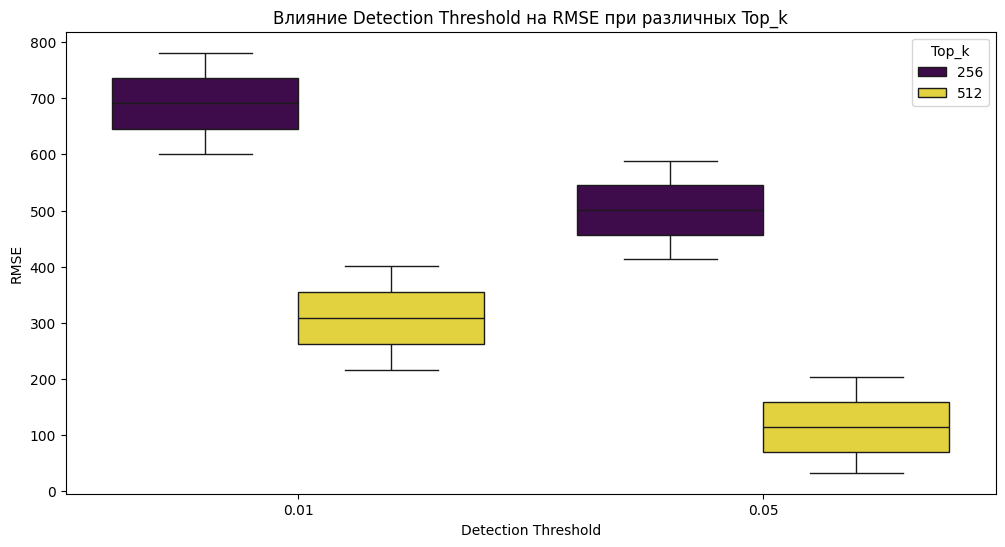

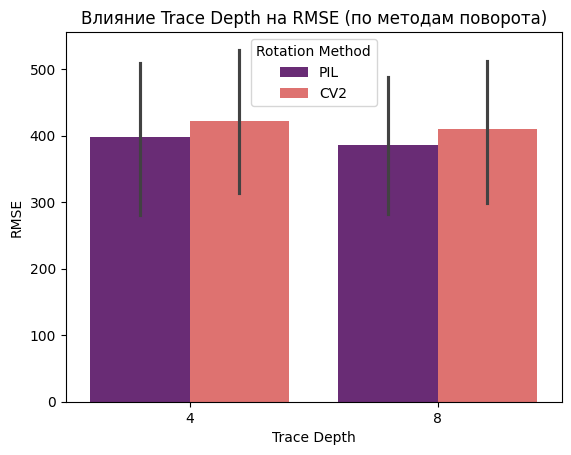

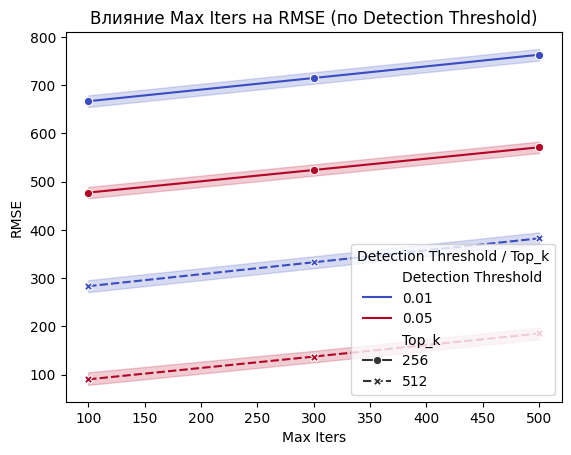

In [31]:
plt.figure(figsize=(12, 6))

# График 1: Зависимость RMSE от Detection Threshold
sns.boxplot(data=df, x='Detection Threshold', y='RMSE', hue='Top_k', palette='viridis')
plt.title('Влияние Detection Threshold на RMSE при различных Top_k')
plt.xlabel('Detection Threshold')
plt.ylabel('RMSE')
plt.legend(title='Top_k')
plt.show()

# График 2: Влияние Trace Depth
sns.barplot(data=df, x='Trace depth', y='RMSE', hue='Rotation method', palette='magma')
plt.title('Влияние Trace Depth на RMSE (по методам поворота)')
plt.xlabel('Trace Depth')
plt.ylabel('RMSE')
plt.legend(title='Rotation Method')
plt.show()

# График 3: Влияние Max Iters
sns.lineplot(data=df[df['Max Iters'] != 'None'], x='Max Iters', y='RMSE', hue='Detection Threshold', style='Top_k', markers=True, palette='coolwarm')
plt.title('Влияние Max Iters на RMSE (по Detection Threshold)')
plt.xlabel('Max Iters')
plt.ylabel('RMSE')
plt.legend(title='Detection Threshold / Top_k')

#plt.tight_layout()
plt.show()

In [32]:
# Поиск минимального значения RMSE
min_rmse = df['RMSE'].min()

# Устанавливаем порог RMSE (минимальный RMSE + N метр)
threshold_rmse = min_rmse + 300

# Фильтрация конфигураций с RMSE ≤ минимальное значение RMSE + N метр
df_acceptable = df[df['RMSE'] <= threshold_rmse]

# Если есть конфигурации с допустимой точностью
if not df_acceptable.empty:
    # Выбираем конфигурацию с максимальным FPS
    best_acceptable = df_acceptable.loc[df_acceptable['Avg FPS'].idxmax()]
    print(f"Лучшая конфигурация с минимальным RMSE (добавлен {threshold_rmse - min_rmse} метр): \n{best_acceptable}")
else:
    # Если нет конфигураций с RMSE ≤ минимальное значение, то выбираем конфигурацию с максимальным FPS
    best_overall = df.loc[df['Avg FPS'].idxmax()]
    print(f"Конфигурация с максимальным FPS (при RMSE > {threshold_rmse}): \n{best_overall}")

Лучшая конфигурация с минимальным RMSE (добавлен 300.0 метр): 
Top_k                         512
Detection Threshold          0.05
Max Iters                   100.0
Rotation method               CV2
Trace depth                     4
Max Distance           125.788068
Min Distance            66.017049
RMSE                   107.684453
Avg FPS                  5.133333
Name: 7, dtype: object
